# 归一化

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import PIL.Image as Image
import numpy as np
import torchvision.transforms as transforms

c:\Users\dongl\.conda\envs\d2l\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] 找不到指定的程序。
  warn(f"Failed to load image Python extension: {e}")


In [2]:
mario = Image.open("images/mario.png")
mario_gray = mario.convert("L")
template = Image.open("images/template16x16.png")
template_gray = template.convert("L")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])
mario_tensor = transform(mario_gray)
template_tensor = transform(template_gray)
mario_tensor.shape, template_tensor.shape

(torch.Size([1, 240, 225]), torch.Size([1, 16, 16]))

In [4]:
mario_tensor.mean(), mario_tensor.std(), template_tensor.mean(), template_tensor.std()

(tensor(0.1561), tensor(0.2291), tensor(0.2312), tensor(0.2633))

In [5]:
class ConvNorm(nn.Module):
    def __init__(self, input_shape, template_shape):
        super(ConvNorm, self).__init__()
        self.layer_norm_t = nn.LayerNorm(template_shape)
        self.layer_norm_x = nn.LayerNorm(input_shape)

    def forward(self, x, template):
        return F.conv2d(self.layer_norm_x(x), self.layer_norm_t(template))

In [6]:
model = ConvNorm(input_shape=[1, 240, 225], template_shape=[1, 16, 16])

In [7]:
with torch.no_grad():
    R_CCORR_NORM = model(mario_tensor.unsqueeze(0), template_tensor.unsqueeze(0))

In [8]:
R_CCORR_NORM.shape

torch.Size([1, 1, 225, 210])

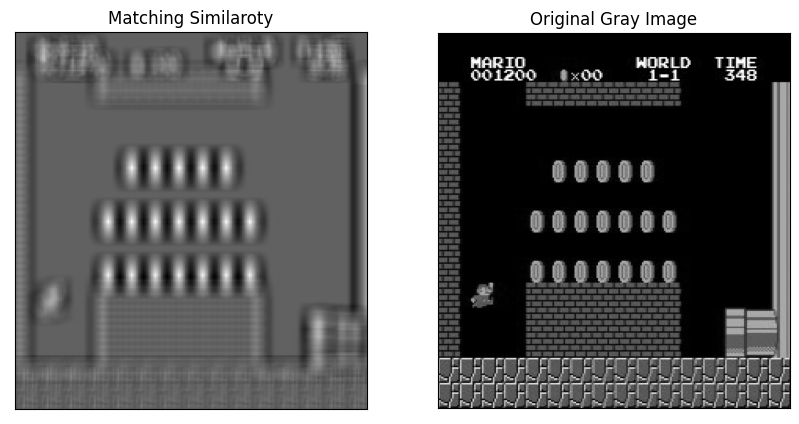

In [9]:
R_CCORR_NORM = R_CCORR_NORM.numpy().squeeze()
mario_gray_np = mario_tensor.numpy().squeeze()
import matplotlib.pyplot as plt
plt.figure("Matching Similaroty vs Original Gray Image", figsize=(10, 5))
plt.subplot(121),plt.imshow(R_CCORR_NORM,cmap = 'gray')
plt.title('Matching Similaroty'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(mario_gray_np,cmap = 'gray')
plt.title('Original Gray Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [10]:
R_CCORR_NORM.max(), R_CCORR_NORM.min()

(293.62378, -181.18547)

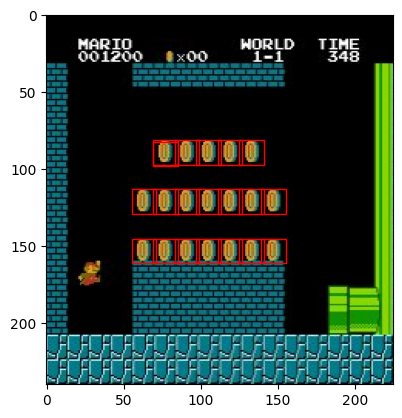

In [11]:
import matplotlib.patches as patches
plt.imshow(mario)
threshold = 250
loc = np.where( R_CCORR_NORM > threshold)
_ , h, w = template_tensor.shape
for pt in zip(*loc[::-1]):
    # print(pt)
    rect = patches.Rectangle(pt, w, h, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

plt.show()

> 这一次貌似成功了的样子，但是这里我们对图片做的不是区域归一化而是全局归一化，而模板匹配是做的区域归一化，但我们依然取得了比较好的效果，把所有的点都找了出来，也没有失误。